#MRI Brain Tumor detection

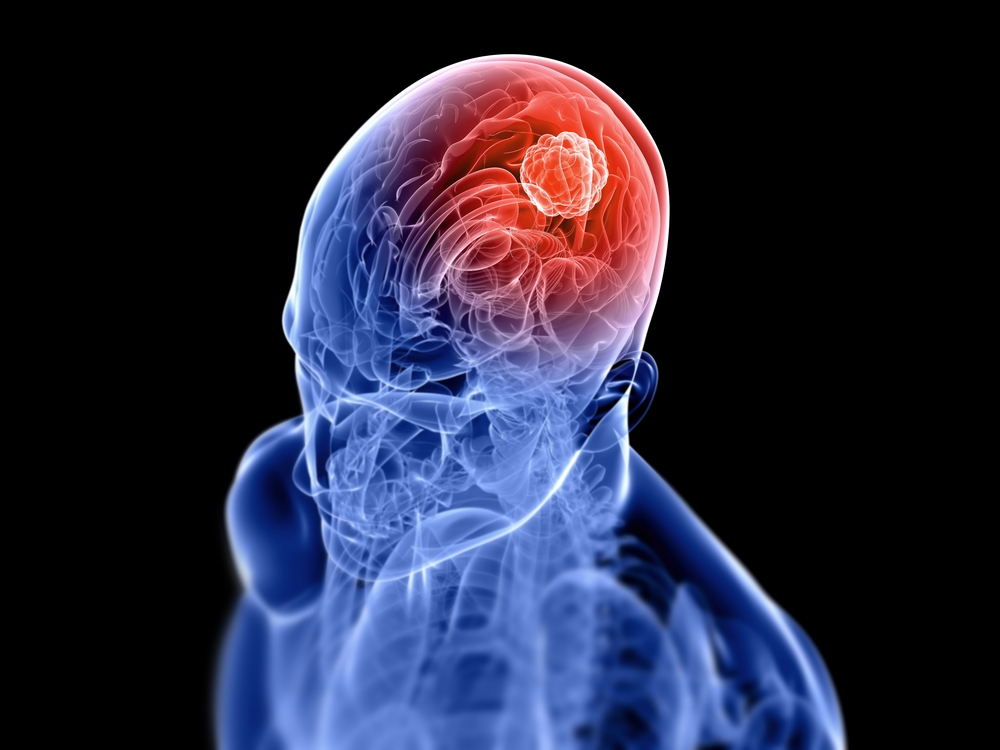

Here we have an image bank of Brain Tumor divided into 2 classes (Yes or Not), we have 342 images divided between Training and Test, here in this study we will analyze the images and perform all the training of the neural network using Keras to perform the classification of these images.
Here we are going to use Keras MobileNetV2 to make the whole model.

### Importing Data

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle kernels pull raphaelmarconato/brain-tumor-classification-images-95-14

In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/brain-mri-images-for-brain-tumor-detection.zip')
zip_ref.extractall('/content')
zip_ref.close()

### Importing Libraries

In [38]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path 

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

### Importing Images. 
Here we are reading the images using the name "image_dir" in the variable.

In [39]:
image_dir = Path('/content/brain_tumor_dataset')

In [40]:
#Here we are getting all the links inside the image bank.
filepaths = list(image_dir.glob(r'**/*.jpg'))

In [41]:
#Here we are separating the image class from the rest of the link.
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [42]:
#Here we are creating a dataframe with a column with the image link and another column with the class.
filepaths = pd.Series(filepaths, name = 'Filepath').astype('string')
label = pd.Series(labels, name = 'Label')
image_df = pd.concat([filepaths, label], axis = 1)

In [43]:
#Transforming Data into Train e Test, here we will use 30% of our data to test the models.
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

<Axes: title={'center': 'Labels'}, xlabel='Label', ylabel='count'>

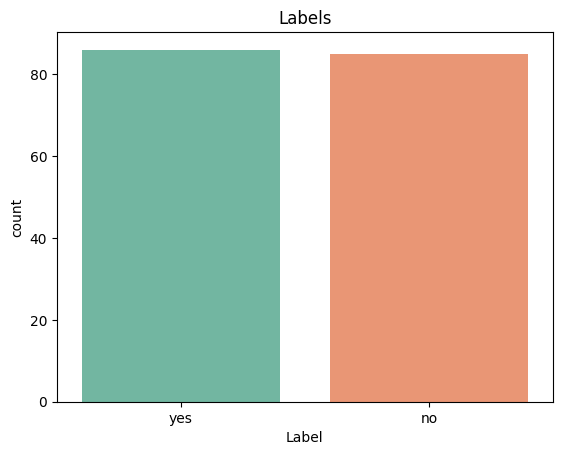

In [44]:
#Here we are going to visualize the count of classes that we have in our training image bank, we can verify that it is well distributed and separated between the two classes.
import seaborn as sns
import matplotlib.pyplot as plt

plt.gca().set_title('Labels')
sns.countplot(x = 'Label', palette = 'Set2', data = image_df)

In [45]:
#Creating Generators.
#Here we are going to create the generator to read the images little by little so as not to overload the computer, let's separate our image bank into 3 parts, training, validation and testing, as we have 2 classes, we will use the "Binary" method.
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [46]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False
)

Found 96 validated image filenames belonging to 2 classes.
Found 23 validated image filenames belonging to 2 classes.
Found 52 validated image filenames belonging to 2 classes.


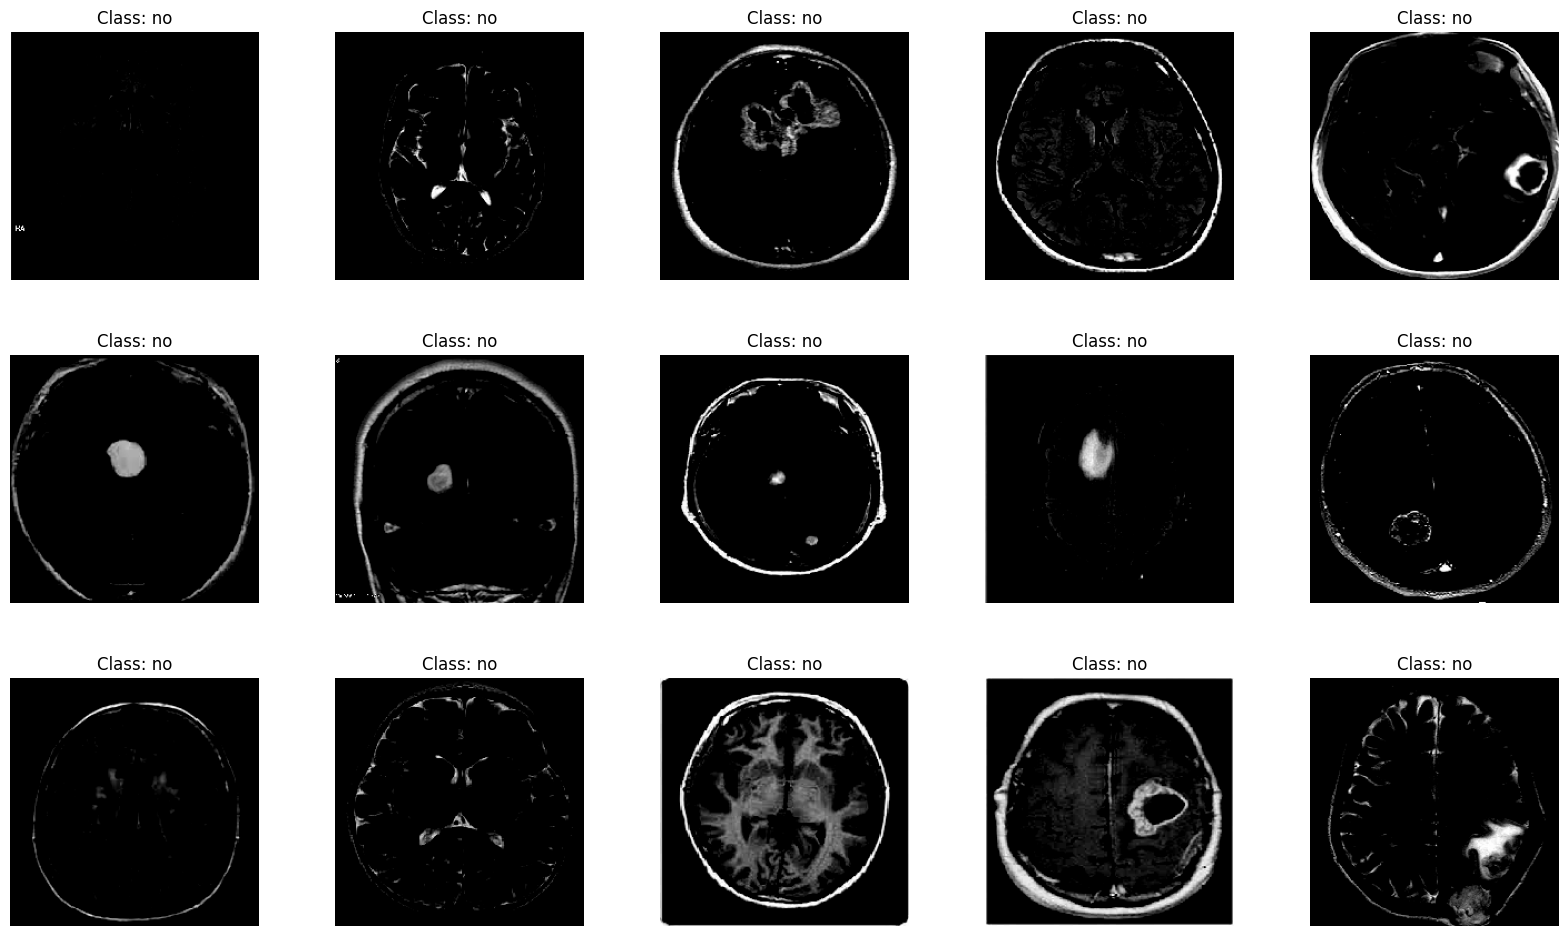

In [47]:
#Here we are viewing some images of our training dataset, we can see both classes.
labels = [k for k in train_images.class_indices]
sample_generate = train_images.__next__()

images = sample_generate[0]
titles = sample_generate[1]
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(5 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Class: {labels[np.argmax(titles[i],axis=0)]}')
    plt.axis("off")

### Creating the Model.

In [48]:
#Downloading Feacture Exctraction
feature_extractor = tf.keras.applications.MobileNetV2(
    input_shape = (224, 224, 3),
    weights = 'imagenet',
    include_top = False,
    pooling = 'avg'
)

feature_extractor.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


### Training the Model.
Here in model training we will create two neural networks with 128 neurons each using the relu as activation, in the output we will use the sigmoid as activation and a neuron with 1 output, since we have a binary result, as optimizer we will use Adams, the metric for loss we will use categorical_crossentropy and accuracy as a metric.

In [49]:
inputs = feature_extractor.input
x = tf.keras.layers.Dense(128, activation='relu')(feature_extractor.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [51]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
3/3 [==============================] - 1s 368ms/step - loss: 0.0369 - accuracy: 1.0000 - val_loss: 0.2032 - val_accuracy: 0.8696
Epoch 2/100
3/3 [==============================] - 1s 272ms/step - loss: 0.0239 - accuracy: 1.0000 - val_loss: 0.1972 - val_accuracy: 0.8696
Epoch 3/100
3/3 [==============================] - 1s 271ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.1667 - val_accuracy: 0.9130
Epoch 4/100
3/3 [==============================] - 1s 275ms/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.1601 - val_accuracy: 0.8696
Epoch 5/100
3/3 [==============================] - 1s 228ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.1786 - val_accuracy: 0.9130
Epoch 6/100
3/3 [==============================] - 1s 227ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 0.1944 - val_accuracy: 0.8696
Epoch 7/100
3/3 [==============================] - 1s 226ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.1847 - val_accuracy: 0.9130
Epoch 8/100
3

### Conclusion. 
Looking at our model we can see that we don't have a large bank of images but we got a good result, when analyzing the images we can see that we have 2 results (Yes or No).
Here we used MobileNetV2 to classify the images, we created a neural network using Keras, we created 2 neural networks with 128 neurons using relu as activation, then we created an output neural network with 1 output neurons (because we have a binary result) using sigmoid as activation.
Testing our model on the set of test images we obtained 95.65% accuracy, a good result, when we analyze the classes we can see that we had success in preview both results.

In [53]:
predictions = np.squeeze(model.predict(test_images))
predictions = (predictions >= 0.5).astype(int)
acc = accuracy_score(test_images.labels, predictions)

2/2 [==============================] - 2s 674ms/step


In [54]:
classification_random = (classification_report(test_images.labels, predictions, target_names = labels))
print(classification_random)

              precision    recall  f1-score   support

          no       0.85      1.00      0.92        22
         yes       1.00      0.87      0.93        30

    accuracy                           0.92        52
   macro avg       0.92      0.93      0.92        52
weighted avg       0.93      0.92      0.92        52

